In [1]:
import numpy as np 
import pandas as pd
import os
import datetime
import matplotlib.pyplot as plt
import urllib
import json
import io
import warnings
warnings.filterwarnings("ignore")
from scipy.integrate import quad #for integrals
from Sources import sources
import random
from astropy.io import fits
import scipy.stats as st


In [2]:
hdul = fits.open('gll_psc_v27.fit')
hdul.info()

Filename: gll_psc_v27.fit
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       9   ()      
  1  LAT_Point_Source_Catalog    1 BinTableHDU    435   5788R x 74C   [18A, I, E, E, E, E, E, E, E, E, E, E, I, 18A, E, E, E, E, E, E, 17A, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, 7E, 14E, 7E, 7E, E, E, E, E, E, E, D, E, 10E, 20E, 10E, 18A, 18A, 18A, 18A, 18A, A, 26A, 5A, 5A, 28A, 26A, E, E, D, D, E, I]   
  2  ExtendedSources    1 BinTableHDU     74   75R x 11C   [17A, E, E, E, E, 11A, E, E, E, 11A, 24A]   
  3  ROIs          1 BinTableHDU    121   1519R x 12C   [I, E, E, E, E, E, E, E, E, E, E, E]   
  4  Components    1 BinTableHDU     53   15R x 9C   [E, E, I, I, E, E, E, I, I]   
  5  EnergyBounds    1 BinTableHDU     75   19R x 10C   [E, E, E, I, I, E, E, E, I, I]   
  6  Hist_Start    1 BinTableHDU     42   11R x 1C   [D]   
  7  GTI           1 BinTableHDU     39   57987R x 2C   [D, D]   


In [3]:
hdul[1].header

XTENSION= 'BINTABLE'           / binary table extension                         
BITPIX  =                    8 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                  752 /   length of dimension 1                        
NAXIS2  =                 5788 / length of dimension 2                          
PCOUNT  =                    0 / number of group parameters                     
GCOUNT  =                    1 / number of groups                               
TFIELDS =                   74 /   number of table fields                       
COMMENT                                                                         
COMMENT  *** End of mandatory fields ***                                        
COMMENT                                                                         
COMMENT                                                                         
COMMENT  *** Column names **

In [5]:
#hdul[1].data[0]['Source_Name'],hdul[1].data[0]["Unc_Flux1000"]
names=(hdul[1].data[:]["Source_Name"]).squeeze().byteswap().newbyteorder()
aveflux=(hdul[1].data[:]["Flux1000"]).squeeze().byteswap().newbyteorder() #photon flux 1-100Gev
Eaveflux=(hdul[1].data[:]["Energy_Flux100"]).squeeze().byteswap().newbyteorder() #energy flux 0.1-100Gev
spectype=(hdul[1].data[:]["SpectrumType"]).squeeze().byteswap().newbyteorder()
PL_Index=(hdul[1].data[:]["PL_Index"]).squeeze().byteswap().newbyteorder()
PLN0=(hdul[1].data[:]["PL_Flux_Density"]).squeeze().byteswap().newbyteorder()
E0=(hdul[1].data[:]["Pivot_Energy"]).squeeze().byteswap().newbyteorder()
LP_Index=(hdul[1].data[:]["LP_Index"]).squeeze().byteswap().newbyteorder()
LPN0=(hdul[1].data[:]["LP_Flux_Density"]).squeeze().byteswap().newbyteorder()
LP_Beta=(hdul[1].data[:]["LP_Beta"]).squeeze().byteswap().newbyteorder()
uncaveflux=(hdul[1].data[:]["Unc_Flux1000"]).squeeze().byteswap().newbyteorder()
Euncaveflux=(hdul[1].data[:]["Unc_Energy_Flux100"]).squeeze().byteswap().newbyteorder()
assName=(hdul[1].data[:]["ASSOC1"]).squeeze().byteswap().newbyteorder()
varIndxFermi=(hdul[1].data[:]["Variability_Index"]).squeeze().byteswap().newbyteorder()

d={"name":names, "AssName":assName, "VIF":varIndxFermi, "Eflux_0.1-100":Eaveflux, "Eflux_err_0.1-100":Euncaveflux, "Phflux_1-100":aveflux, "Phflux_err_1-100":uncaveflux, "SpecType":spectype, "PivEne":E0 \
   ,"PLIndex":PL_Index,"PLN0":PLN0 , "LPAlpha":LP_Index ,"LPBeta":LP_Beta , "LPN0":LPN0}
dfave=pd.DataFrame(data=d)
names=[i[:-1] for i in dfave["name"].values]
dfave["name"]=names

In [6]:
dfave.head()

,name,AssName,VIF,Eflux_0.1-100,Eflux_err_0.1-100,Phflux_1-100,Phflux_err_1-100,SpecType,PivEne,PLIndex,PLN0,LPAlpha,LPBeta,LPN0
0,4FGL J0000.3-7355,,14.022921,1.622461e-12,3.133415e-13,1.420555e-10,2.605565e-11,PowerLaw,2197.597168,2.194066,3.026206e-14,2.300162,-0.058961,2.733629e-14
1,4FGL J0000.5+0743,,17.717155,2.271563e-12,4.391582e-13,1.730381e-10,3.665789e-11,PowerLaw,1025.423706,2.393316,2.273288e-13,1.839048,0.482767,3.100810e-13
2,4FGL J0001.2+4741,B3 2358+474,20.018730,1.406756e-12,4.079498e-13,1.215924e-10,3.206694e-11,PowerLaw,2514.941650,2.222155,1.920634e-14,2.233714,-0.008457,1.893531e-14
3,4FGL J0001.2-0747,PMN J0001-0746,33.228680,9.171432e-12,6.173061e-13,8.232051e-10,5.677742e-11,PowerLaw,1612.614136,2.104943,3.346566e-13,2.071893,0.048770,3.583349e-13
4,4FGL J0001.5+2113,TXS 2358+209,1564.417603,2.614211e-11,7.895439e-13,1.359053e-09,6.859886e-11,LogParabola,355.784424,2.659308,3.905111e-11,2.548151,0.158776,4.532746e-11


In [15]:
def PowLawFunc(E,N0,E0,gamma):
    func=N0*pow((E/E0),-gamma)
    return func

def LogParFunc(E,N0,E0,alpha,beta):
    func=N0*pow((E/E0),-(alpha+beta*np.log(E/E0))) #not log10, it is natural log.
    return func


In [9]:
def computeDate(MET):

    if MET>252460801: MET=MET-1 # 2008 leap second
    if MET>157766400: MET=MET-1 # 2005 leap second
    if MET>362793601: MET=MET-1 # 2012 leap second
    if MET>457401601: MET=MET-1 # 2015 leap second
    if MET>504921601: MET=MET-1 # 2016 leap second
    #after 2018 till now there is no leap second
    
    metdate  = datetime.datetime(2001, 1, 1,0,0,0)
    dt=datetime.timedelta(seconds=MET)
    date=metdate + dt
    yy=date.year
    mm=date.month
    dd=date.day
    hr=date.hour
    mi=date.minute
    ss=date.second
    fff=(float(ss+60.*mi+3600.*hr)/86.4)/1000.0

    return date, fff

def computeMJD(MET, returnFraction=True):

    # Get the date and fraction of day for the given MET
    date, fraction = computeDate(MET)
    #print(date)

    # Calculate the number of days since January 1, 4713 BC
    # JD = date.toordinal() + 1721424.5 (number of days before 01/01/01 till January 1, 4713 B.C.E)
    # date.toordinal() gives the number of days after the 01/01/01 till the date specified
    JD = date.toordinal() + 1721425

    # Calculate the number of days since November 17, 1858
    # MJD = JD - 2400000.5
    MJD = JD - 2400001

    if returnFraction == True:
        MJD = MJD + fraction

    return MJD

In [10]:
#this function is from PyLCR fermi github source (https://github.com/dankocevski/pyLCR).
def getLightCurveData(source, cadence='daily', flux_type='photon', index_type='fixed', ts_min=4):
    """Download data from the light curve repository
    Arguments:
        source (str):           A 4FGL catalog name, e.g. '4FGL J0001.2-0747'
        cadence (str):          Specifies the requested light curve cadence. Options include: 'daily', 'weekly', and 'monthly'
        flux_type (str):        Specifies the requested flux type. Options include 'photon' and 'energy'
        index_type (str):       Specifies the spectral index freedom during fit. Options include 'free' and 'fixed'
        ts_min (int):           The minimum likelihood ratio test statistic for which a flux estimate is reported as opposed to an upper limit.
    Returns:
        A key-value pair dictionary containing numpy arrays of light curve data
    """

    if source not in sources:
        #print("\nError: %s is not a source that is tracked by the LCR." % source)
        return

    if 'daily' not in cadence and 'weekly' not in cadence and 'monthly' not in cadence:
        print("\nError: Unrecognized cadence.")
        print("\nThe cadence keyword specifies the requested light curve cadence. Options include: 'daily', 'weekly', and 'monthly'")
        return 

    if 'photon' not in flux_type and 'energy' not in flux_type:
        print("\nError: Unrecognized flux type.")
        print("\nThe flux_type keyword specifies the requested flux type. Options include 'photon' and 'energy'")
        return

    if 'fixed' not in index_type and 'free' not in flux_type:
        print("\nError: Unrecognized spectral index type.")
        print("\nThe index_type keyword specifies the spectral index freedom during fit. Options include 'free' and 'fixed'")
        return

    # Create a quoted source
    source_quoted = urllib.parse.quote(source)

    # Create the url template
    url_template = ("https://fermi.gsfc.nasa.gov/ssc/data/access/lat/LightCurveRepository/queryDB.php?typeOfRequest=lightCurveData"
    "&source_name={source_name}&cadence={cadence}&flux_type={flux_type}&index_type={index_type}&ts_min={ts_min}")

    # Fill the url template
    url = url_template.format(**{"source_name": source_quoted,
       "cadence": cadence,
       "flux_type": flux_type,
       "index_type": index_type,
       "ts_min": ts_min})

    # Create a json filename
    filename = '_'.join([source_quoted, cadence, flux_type, index_type, "tsmin" + str(ts_min)])
    filename += ".json"

    #print("\nDownloading data for %s..." % source)

    try:

        # Open the url
        with urllib.request.urlopen(url) as response:

            # Parse the downloaded data
            data = json.loads(response.read().decode())

            # Check the http status code to see if the data was downloaded successfully
            code = int(response.code)
            '''if code >= 200 and code <= 299 and len(data['ts']) > 0:
                print('Done.')'''

    # Parse the status codes of any failures
    except urllib.error.HTTPError  as e:
        print("HTTP Error.")
        print("Return Code", e.code)

    except urllib.error.URLError as e:
        if hasattr(e, 'reason'):
            print("Return Code", e.reason)

        elif hasattr(e, 'code'):
            print("Return Code", e.code)

   
    data['ts'] = np.array(data['ts'])[:,0], np.array(data['ts'])[:,1]
    data['flux'] = np.array(data['flux'])[:,0], np.array(data['flux'])[:,1]
    #print(numpy.array(data['flux_upper_limits']).shape[0])
    if np.array(data['flux_upper_limits']).shape[0]>0:
        data['flux_upper_limits'] = np.array(data['flux_upper_limits'])[:,0], np.array(data['flux_upper_limits'])[:,1]
    else:
        data['flux_upper_limits'] =[],[]
    data['flux_error'] = np.array(data['flux_error'])[:,0], np.array(data['flux_error'])[:,1]
    data['photon_index'] = np.array(data['photon_index'])[:,0], np.array(data['photon_index'])[:,1]
    data['photon_index_interval'] = np.array(data['photon_index_interval'])[:,0], np.array(data['photon_index_interval'])[:,1]
    data['fit_tolerance'] = np.array(data['fit_tolerance'])[:,0], np.array(data['fit_tolerance'])[:,1]
    data['fit_convergence'] = np.array(data['fit_convergence'])[:,0], np.array(data['fit_convergence'])[:,1]
    data['dlogl'] = np.array(data['ts'])[:,0], np.array(data['dlogl'])
    data['EG'] = np.array(data['ts'])[:,0], np.array(data['EG'])
    data['GAL'] = np.array(data['ts'])[:,0], np.array(data['GAL'])
    data['bin_id'] = np.array(data['ts'])[:,0], np.array(data['bin_id'])

    return data

In [11]:
def get_fermi_data_upp(obj,cad="weekly"):
    data = getLightCurveData(obj, cadence=cad, flux_type='photon', index_type='fixed', ts_min=1)
    
    flag=False
    df=pd.DataFrame()
    if data:
        flag=True
        
        columns = data.get('ts')

        TS = np.array(columns[1])
        TStime=np.array(columns[0])
        
        columns = data.get('flux')

        timeMET = np.array(columns[0])
        

        gamma_flux = np.array(columns[1])

        columns2 = data.get('flux_error')
        gamma_flux_error = columns2[1]

        timeMET_error = columns2[0]
        
        
        columns = data.get('flux_upper_limits')
        timeMET_upp = np.array(columns[0])
        gamma_flux_upp = np.array(columns[1])
        gamma_flux_upp_err=np.zeros(gamma_flux_upp.shape[0])-1
                
        timeMET=np.concatenate([timeMET,timeMET_upp])
        gamma_flux=np.concatenate([gamma_flux,gamma_flux_upp])
        gamma_flux_error=np.concatenate([gamma_flux_error,gamma_flux_upp_err])
        
        if not len(timeMET)==len(TStime):
            timeMiss=np.array([t for t in TStime if not t in timeMET])
            ##because of TS=1 is missing some values of time, we use TS=2 here to fill in for thoes
            datatest = getLightCurveData(obj, cadence=cad, flux_type='photon', index_type='fixed', ts_min=2)
            columnstest = datatest.get('flux_upper_limits')
            timeMET_upptest = np.array(columnstest[0])
            gamma_flux_upptest = np.array(columnstest[1])
            
            fluxmiss=np.array([gamma_flux_upptest[np.where(timeMET_upptest==t)][0] for t in timeMiss]) 
            gamma_flux_upp_err_miss=np.zeros(fluxmiss.shape[0])-1
            
            for tm in timeMET[np.where(gamma_flux<0)]:
                if tm in timeMET_upptest:
                    if gamma_flux_upptest[np.where(timeMET_upptest==tm)]<0:
                        continue
                    else:
                        gamma_flux[np.where(timeMET==tm)]=gamma_flux_upptest[np.where(timeMET_upptest==tm)]
        
            timeMET=np.concatenate([timeMET,timeMiss])
            gamma_flux=np.concatenate([gamma_flux,fluxmiss])
            gamma_flux_error=np.concatenate([gamma_flux_error,gamma_flux_upp_err_miss])
            
               
        d = {"t_MET":timeMET, "flux_ph":gamma_flux, "flux_err":gamma_flux_error}
        df=pd.DataFrame(data=d)
        df=df.sort_values(by=["t_MET"])
        df["TS"]=TS
        df["t_MJD"]=np.round(df.apply(lambda row : computeMJD(row["t_MET"]), axis = 1 ),2)
        cols=["t_MET","t_MJD","flux_ph","flux_err","TS"]
        df=df[cols]
        
        #There are some points in the data file that the flux is -1 by itself
        #I will delete these points as being not observed
        if not (df[df["flux_ph"]<0].empty):
            df=df.drop(df[df["flux_ph"]<0].index.tolist())
            df.reset_index(drop=True,inplace=True)
            
        return df,flag
        
    else:
        print("\nError: %s is not a source that is tracked by the LCR." % obj)
        return df,0

In [12]:
#function to calculate excess variance.
def cal_excvar_Fvar(flux,e_flux,meanF=None):
    
    if not meanF:
        meanF=flux.mean()
        varF= flux.var(ddof=1) #to have 1/(N-ddof) factor for variance
    else:
        varF= (1/(flux.shape[0]-1))*(pow(flux-meanF,2).sum())
        
    mean_sqErr=(e_flux*e_flux).mean()
    
    exc_var=varF-mean_sqErr
        
    Fvar= pow(abs(exc_var)/pow(meanF,2),0.5)
    
    N=flux.shape[0]
    
    p1 = np.sqrt(2.0/N) * mean_sqErr / (meanF*meanF)
    p2 = np.sqrt(mean_sqErr / N) * (2 * Fvar / meanF)
    err_NormExcVar = np.sqrt(p1 * p1 + p2 * p2)
    
    err_Fvar=err_NormExcVar/(2*Fvar)
    
    
    
    return exc_var, err_NormExcVar, Fvar, err_Fvar

The following two functions are trying to clean data by filling the empty bins and mark the non-usable bins.

In [13]:
#Fill in empty bins with -1 regarding time of Tess and Fermi
def completeData_m1(df,t_MJD_1,t_MJD_2,cadance):
    #Add to the begining
    stepi=1
    cadance=7
    addT=[]
    while df["t_MJD"].min()-stepi*cadance>t_MJD_1:
        addT.append(df["t_MJD"].min()-stepi*cadance)
        stepi+=1

    addRest=[-1]*len(addT)
    d={"t_MET":addRest,"t_MJD":addT,"flux_ph":addRest,"flux_err":addRest,"TS":addRest}
    df1=pd.DataFrame(data=d)
    df=pd.concat([df1,df],ignore_index=True)
    #Add to the end
    stepi=1
    addT=[]
    while df["t_MJD"].max()+stepi*cadance<t_MJD_2:
        addT.append(df["t_MJD"].max()+stepi*cadance)
        stepi+=1

    addRest=[-1]*len(addT)
    d={"t_MET":addRest,"t_MJD":addT,"flux_ph":addRest,"flux_err":addRest,"TS":addRest}
    df1=pd.DataFrame(data=d)
    df=pd.concat([df,df1],ignore_index=True)
    
    totT=np.arange(df["t_MJD"].min(),t_MJD_2,cadance)
    addT=[x for x in totT if x not in df["t_MJD"].values]
    addRest=[-1]*len(addT)
    d={"t_MET":addRest,"t_MJD":addT,"flux_ph":addRest,"flux_err":addRest,"TS":addRest}
    df1=pd.DataFrame(data=d)
    df=pd.concat([df,df1],ignore_index=True)
    df=df.sort_values(by=["t_MJD"],ignore_index=True)
    
    return df

In [14]:
#Fill in empty bins regarding not observation with values from the neighboring 
def completeData_neighbor(df,t_MJD_1,t_MJD_2,cadance):
    dfm=df[(df["TS"]<0) | (df["flux_ph"]<0)]
    if not dfm.empty:
        for index,row in dfm.iterrows():
            usei=-1
            useiU=-1
            i=0
            #take the data from the first available data after or before
            while (usei==-1) and (useiU==-1):
                i+=1
                bi=index-i
                ai=index+i

                #take the data from the one previous or after if it is not an upperlimit
                if (bi>=0) and (df["TS"][bi]>=1):
                    usei=bi
                elif (ai<df.shape[0]) and (df["TS"][ai]>=1):
                    usei=ai
                #take the data from the one previous or after as an upperlimit
                elif (bi>0) and (df["TS"][bi]>=0):
                    useiU=bi
                elif (ai<df.shape[0]) and (df["TS"][ai]>=0):
                    useiU=ai
                
            if usei>-1:
                df.loc[index,"flux_ph"]=df["flux_ph"][usei]
                df.loc[index,"flux_err"]=df["flux_err"][usei]
                
            elif useiU>-1:
                df.loc[index,"flux_ph"]=df["flux_ph"][useiU]
                
    return df
    

Ploting flux values with their error bars, showing the average flux on the plot to compare. This comparison can help us to explore the data and understand if we can model the upperlimits.
The average flux is calculated using a model defined as PowerLaw or LogParabola.


4FGL J1800.6+7828


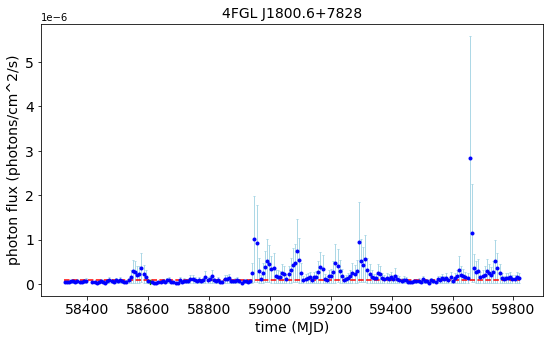

4FGL J1700.0+6830


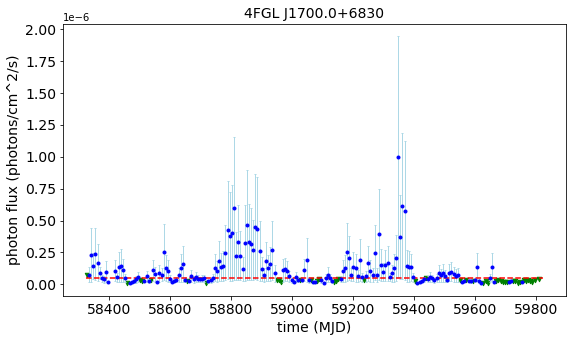

4FGL J1821.6+6819


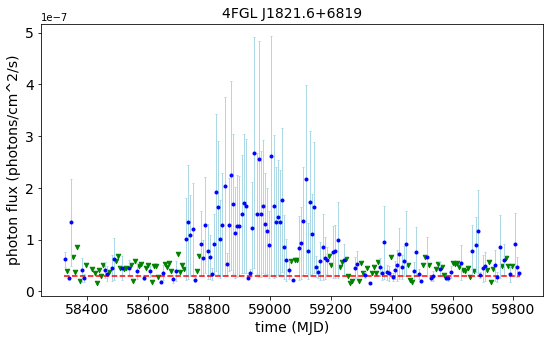

4FGL J0601.1-7035


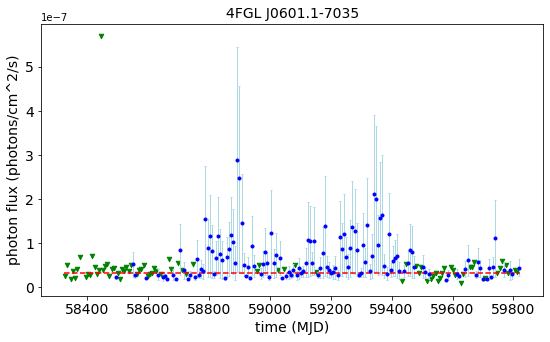

4FGL J1748.6+7005


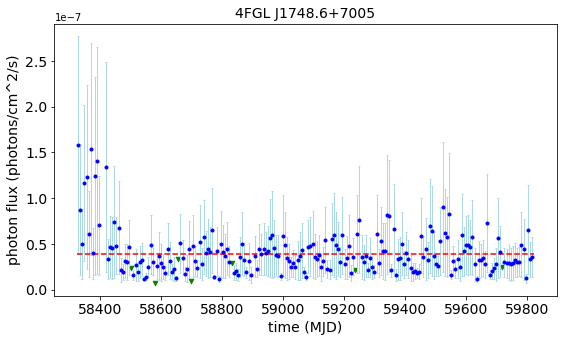

4FGL J1806.8+6949


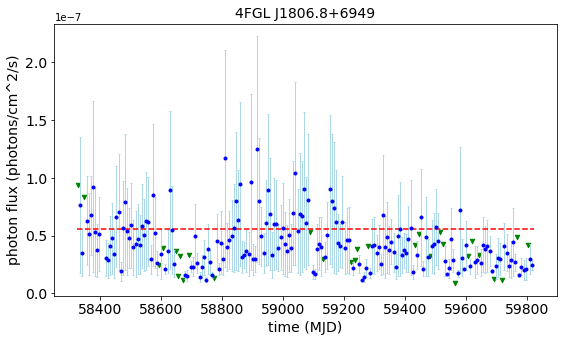

4FGL J0739.8-6722


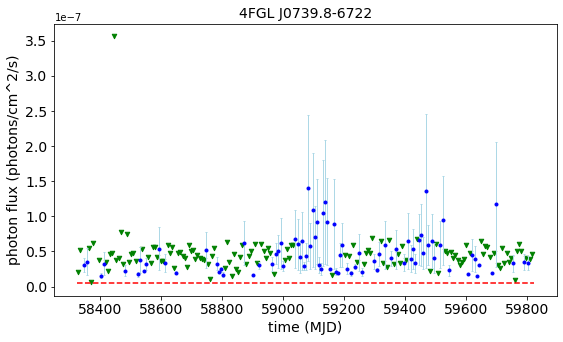

4FGL J1724.9+7654


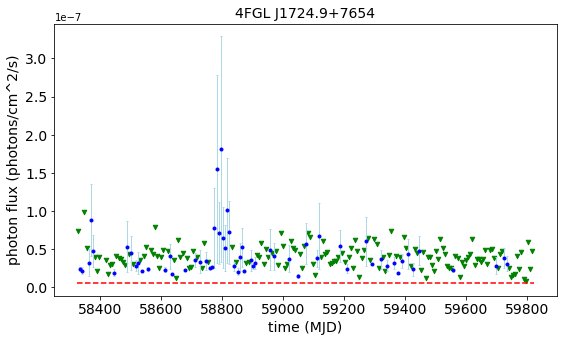

4FGL J1824.1+5651


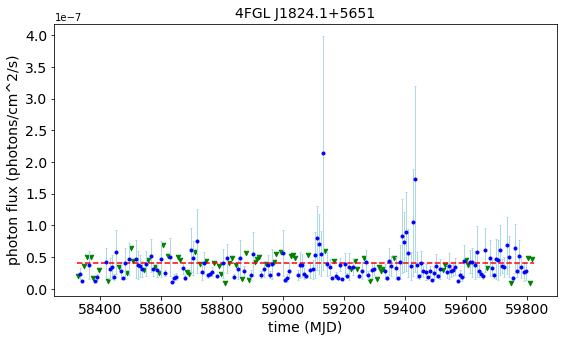

4FGL J1849.2+6705


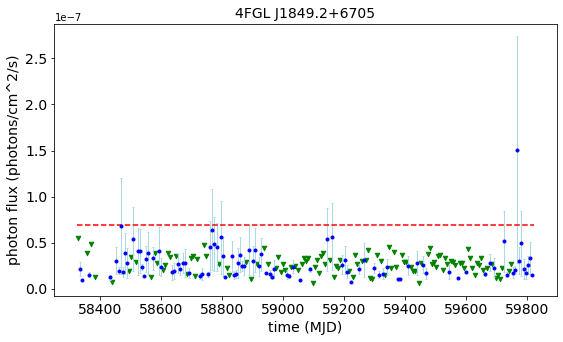

4FGL J1941.7+7218


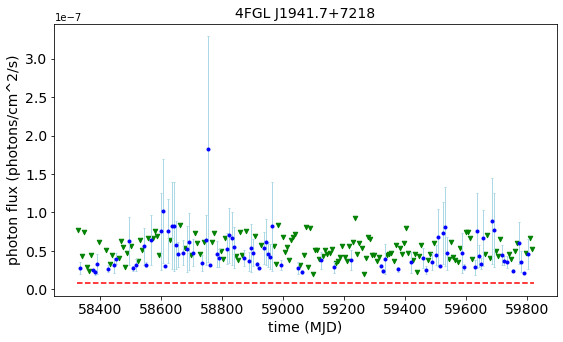

4FGL J0635.6-7518


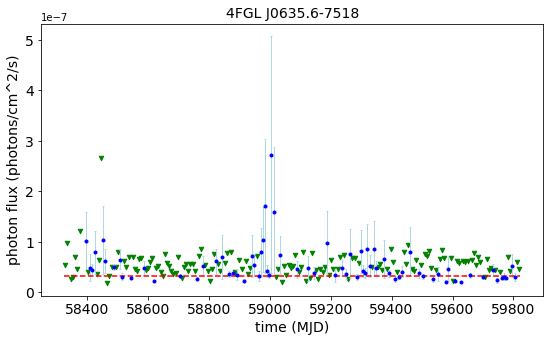

4FGL J0516.7-6207


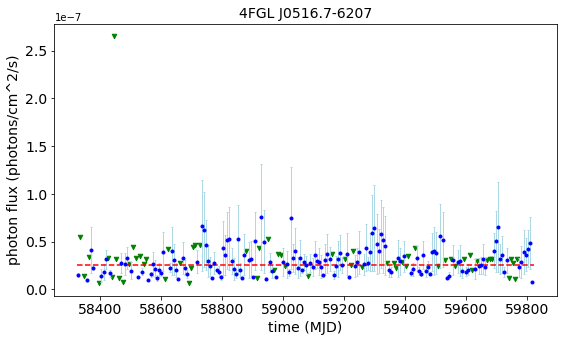

4FGL J0433.6-6030


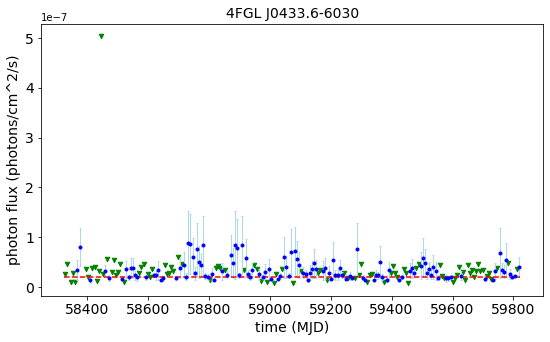

4FGL J0543.9-5531


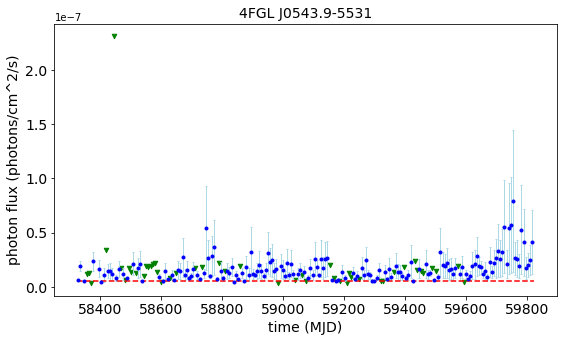

4FGL J0529.3-7243


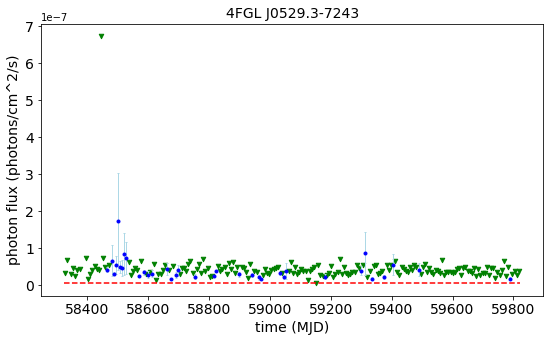

4FGL J0700.5-6610


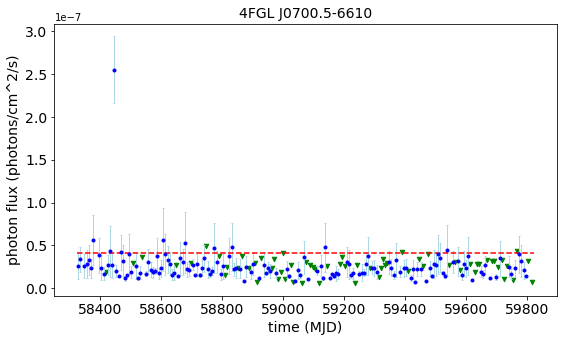

4FGL J1645.6+6329


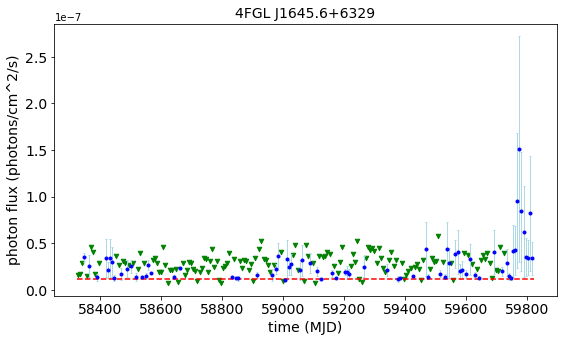

4FGL J1701.0+6613


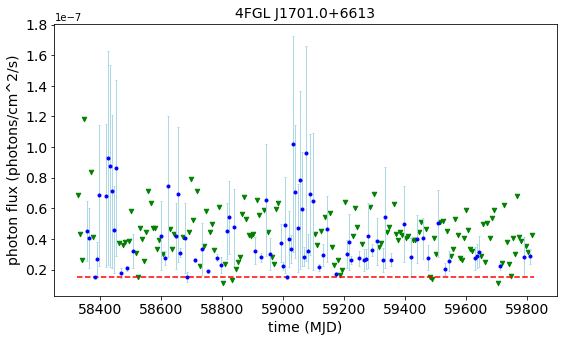

4FGL J0405.4-6929


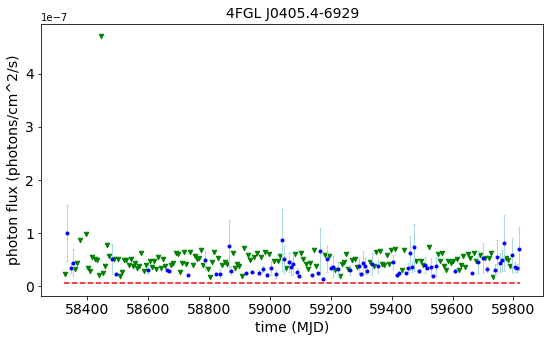

4FGL J1934.3+6541


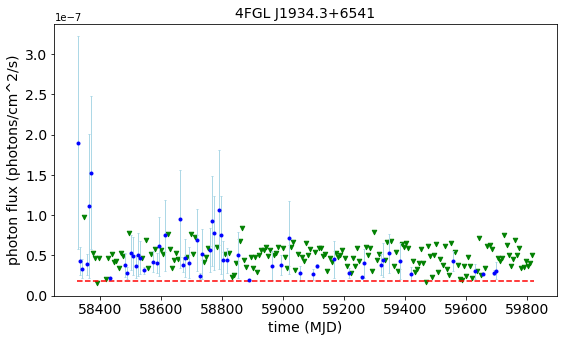

4FGL J0608.9-5456


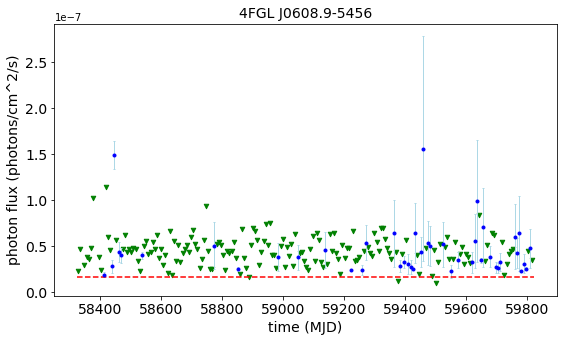

4FGL J0610.9-6054


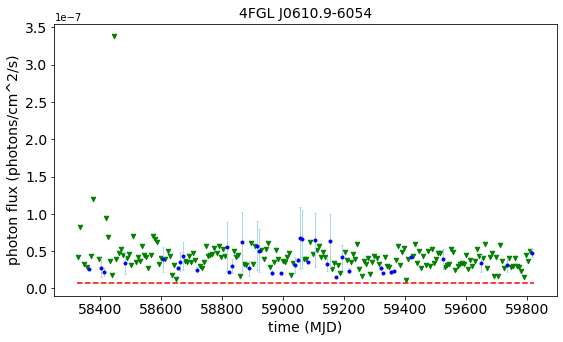

4FGL J0507.7-6104


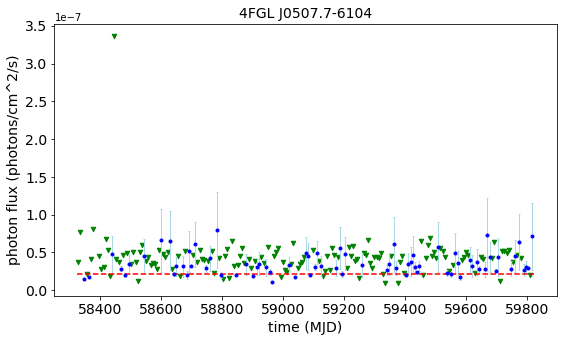

4FGL J1704.1+7647


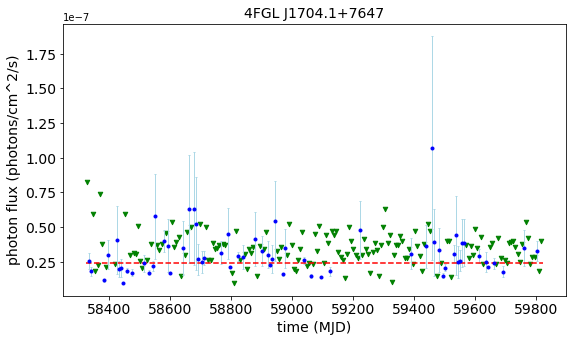

4FGL J1640.3+6850


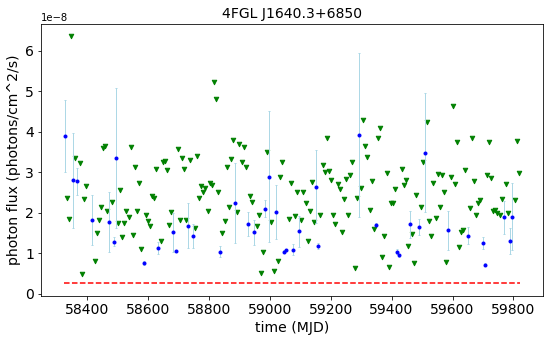

4FGL J0720.0-6237


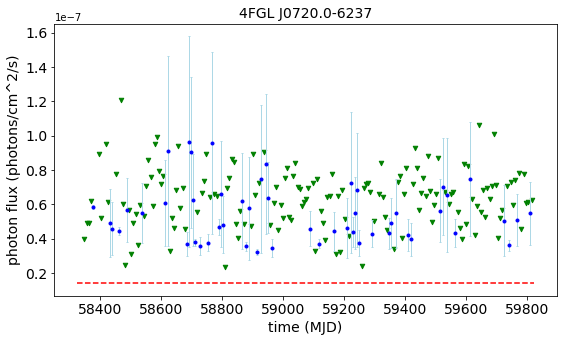

4FGL J1741.2+5739


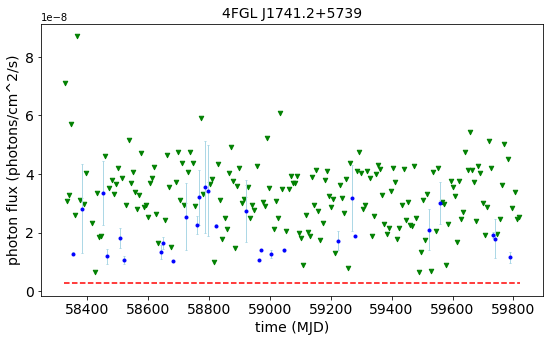

4FGL J1848.5+6537


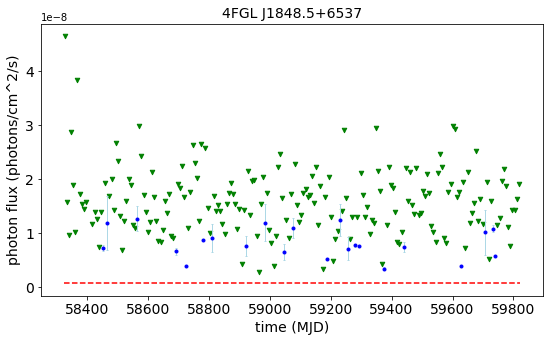

4FGL J1821.6+6636


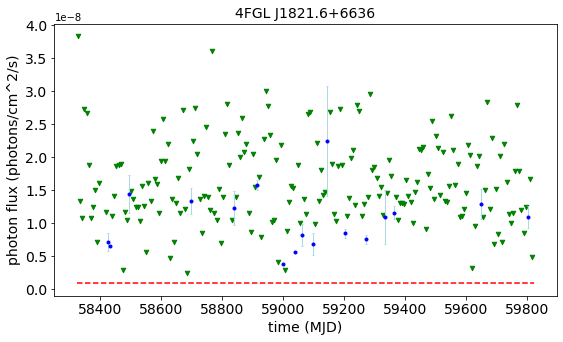

4FGL J1927.5+6117


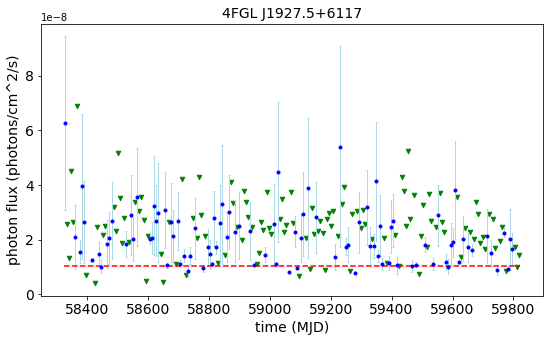

4FGL J1729.0+6103


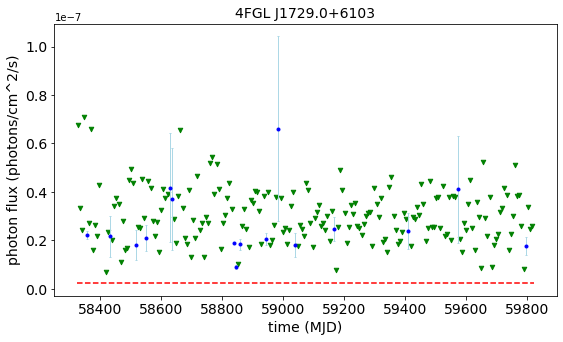

4FGL J1637.7+7326


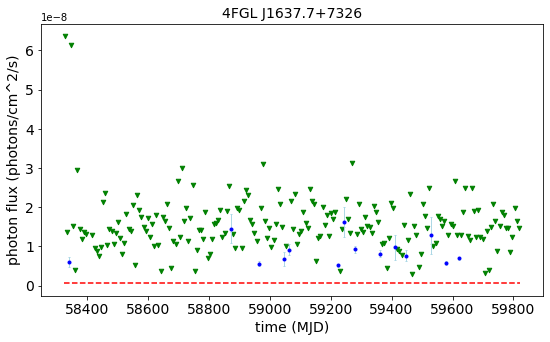

4FGL J1716.1+6836


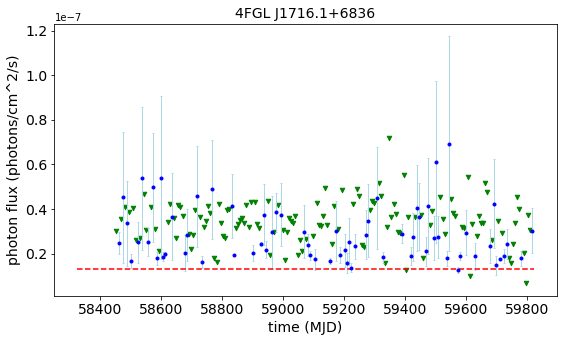

4FGL J1926.8+6154


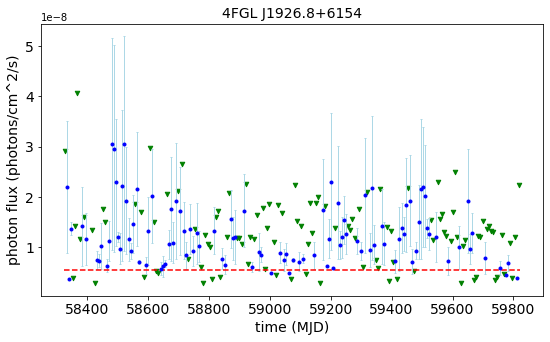

4FGL J0644.4-6712


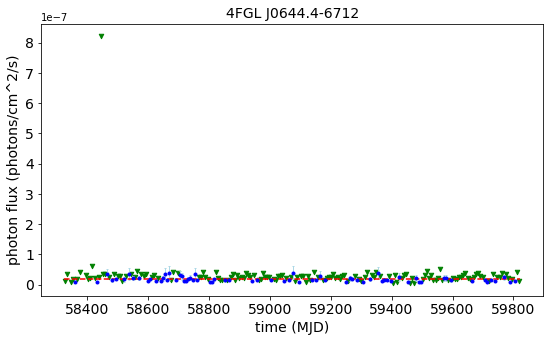

4FGL J0443.3-6652


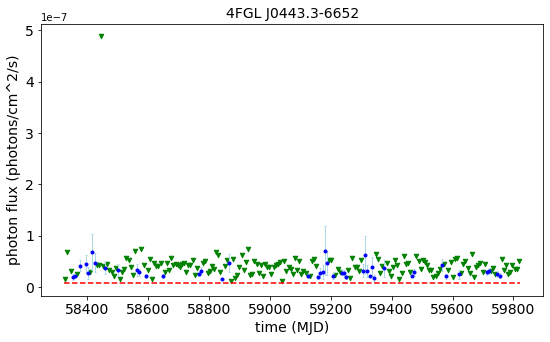

4FGL J1657.0+6010


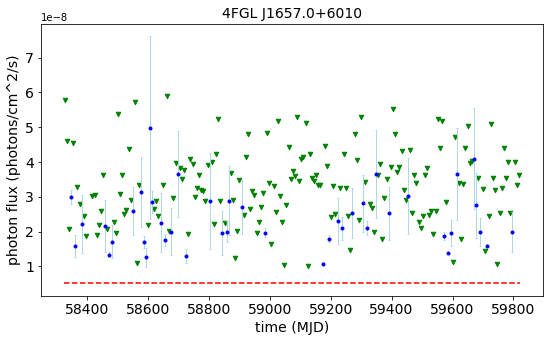

4FGL J1841.0+6115


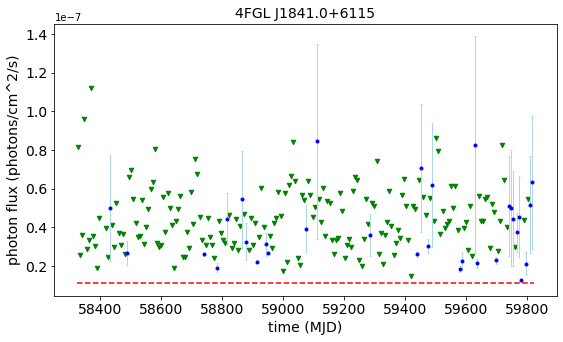

4FGL J1807.2+6429


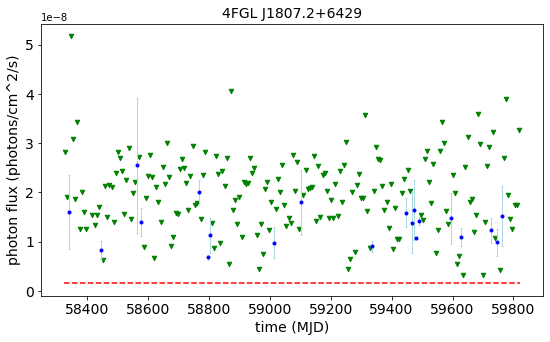

4FGL J0628.8-6250


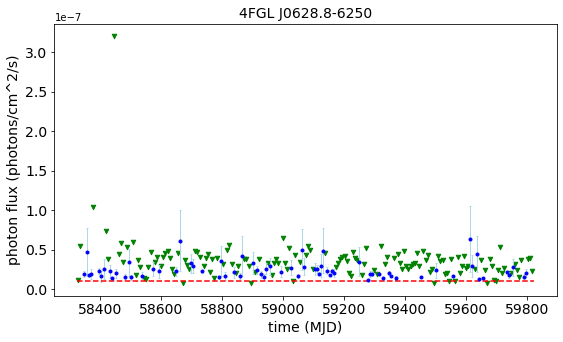

4FGL J0509.9-6417


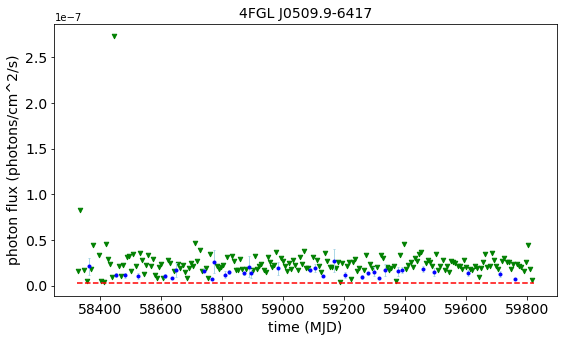

4FGL J1842.3+6810


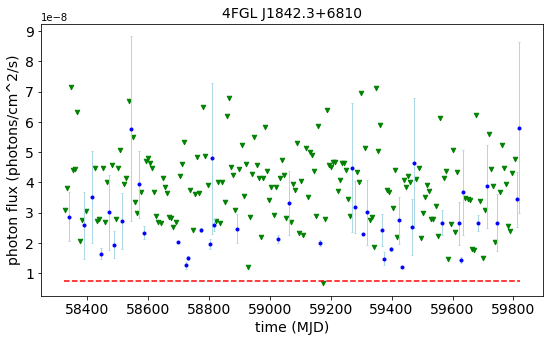

4FGL J0445.1-6012


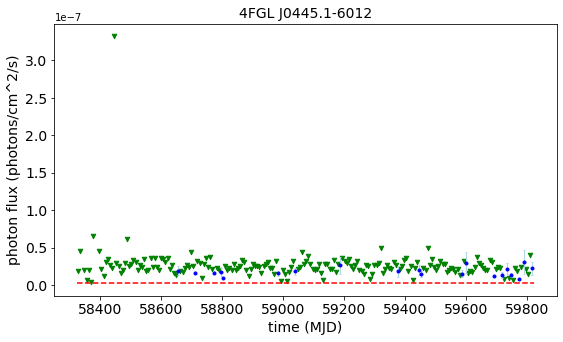

4FGL J1722.6+6104


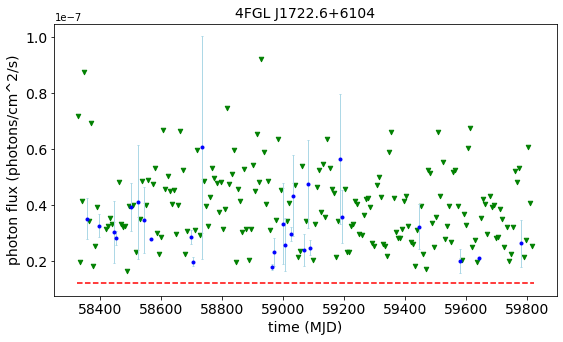

4FGL J2005.1+7003


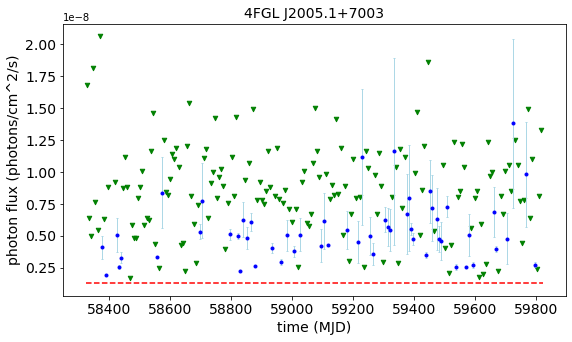

4FGL J0608.1-6028


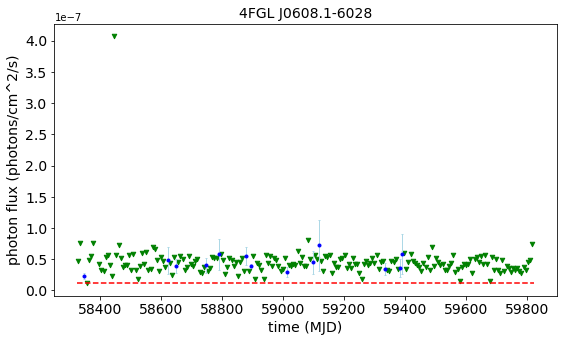

4FGL J1725.5+5851


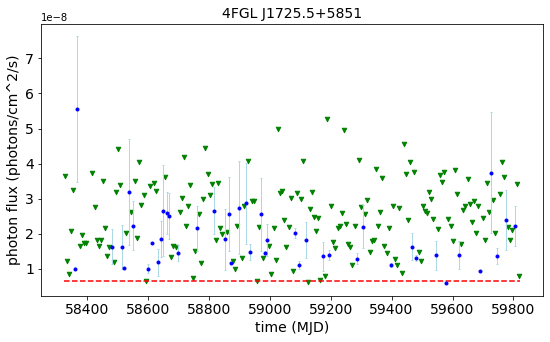

4FGL J0540.0-7552


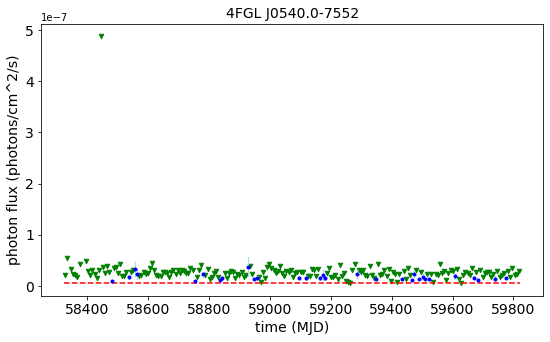

4FGL J0647.7-6058


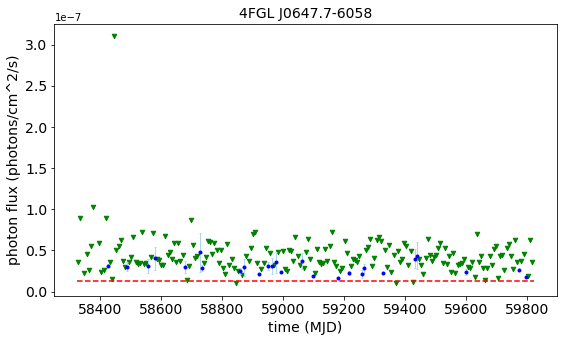

In [299]:
listfileN="LAT_sources_north_CVZ.txt"
df_list=pd.read_csv(listfileN, header=None,sep="|",skiprows=[0],usecols=[1])
df_list.columns=["name"]
listfileN="LAT_sources_south_CVZ.txt"
df_list2=pd.read_csv(listfileN, header=None,sep="|",skiprows=[0,1,2,3,4],usecols=[1])
df_list2.columns=["name"]
n=[]
for i in df_list2["name"].values:
    if i[-1]==" ":
        n.append(i[:-1])
    else:
        n.append(i)
SourceNames=list(df_list["name"].values) + n 

#time in MJD for 07.25.2018 (prob. start time of Tess) till now (09.01.2022)
#https://tess.mit.edu/wp-content/uploads/orbit_times_20220906_1434.csv

t_MJD_1=58324
t_MJD_2=59823
E1=1000
E2=100000
E3=100

cadance={"weekly":7, "monthly":30} #days (weekly)
i=0
for name in SourceNames:
    i+=1
    print(name)
    #if name =="4FGL J0608.9-5456": #in ["4FGL J1821.6+6636","4FGL J1716.1+6836","4FGL J1722.6+6104","4FGL J1645.6+6329","4FGL J1725.5+5851"]:
    dfw,flagw=get_fermi_data_upp(name,"weekly")
    #dfm,flagm=get_fermi_data_upp(name,"monthly")

    if flagw:
        
        
        dfave_s=dfave[dfave["name"]==name]
        spectype=(dfave_s["SpecType"].values[0]).split(" ")[0]
        if spectype=="PowerLaw": #0.1-100GeV
            fluxaveExt=quad(PowLawFunc, 100, 100000, args=(dfave_s["PLN0"].values[0],dfave_s["PivEne"].values[0],dfave_s["PLIndex"].values[0]))[0]
        elif spectype=="LogParabola":
            fluxaveExt=quad(LogParFunc, 100, 100000, args=(dfave_s["LPN0"].values[0],dfave_s["PivEne"].values[0],dfave_s["LPAlpha"].values[0],dfave_s["LPBeta"].values[0]))[0]
        else:
            print("The flux type is not in the list: ",spectype)
            
        

        dfw=dfw[(dfw["t_MJD"]>=t_MJD_1)&(dfw["t_MJD"]<=t_MJD_2)]
        
        if not dfw[dfw["flux_err"]==0].empty:
            for indx in dfw[dfw["flux_err"]==0].index.tolist():
                dfw.loc[indx,"flux_err"]=dfw["flux_ph"][indx]/1e4



        #I filled in -1 for error bars for upperlimits
        #dfw.loc[dfw[dfw["flux_err"]<0].index.tolist(),"flux_err"]=0
        dfupp=dfw[dfw["flux_err"]<0]
        dfdata=dfw[dfw["flux_err"]>=0]
        
        #plot source in this range of time
        x=dfdata["t_MJD"]
        y=dfdata["flux_ph"]
        y_error=dfdata["flux_err"]

        fig, axs = plt.subplots(nrows=1, ncols=1, constrained_layout=False,figsize=(9, 5))
        axs.tick_params(axis='both', which='major', labelsize=14)
        axs.tick_params(axis='both', which='minor', labelsize=14)
        axs.set_title('{}'.format(name), fontsize=14)

        axs.errorbar(x,y,y_error,fmt = ".", color='blue', ecolor='lightblue', elinewidth=1, capsize=1)
        
        
        axs.scatter(dfupp["t_MJD"],dfupp["flux_ph"],marker='v', color='green', s=20)
        
        axs.hlines(fluxaveExt, t_MJD_1,t_MJD_2,color="r", linestyle="dashed")
        axs.set_xlabel('time (MJD)',fontsize=14)
        axs.set_ylabel('photon flux (photons/cm^2/s)',fontsize=14)
        plt.savefig('plots/source_{}.png'.format(i))
        plt.show()

looking at plots, I am defining a costum model to measure the variability including the upperlimits.
We define the least distance between the flux points and the average flux. For the flux with error bars, we find the 95% confidence region and measure the least distance to this region.

In [ ]:
listfileN="LAT_sources_north_CVZ.txt"
df_list=pd.read_csv(listfileN, header=None,sep="|",skiprows=[0],usecols=[1])
df_list.columns=["name"]
listfileN="LAT_sources_south_CVZ.txt"
df_list2=pd.read_csv(listfileN, header=None,sep="|",skiprows=[0,1,2,3,4],usecols=[1])
df_list2.columns=["name"]
n=[]
for i in df_list2["name"].values:
    if i[-1]==" ":
        n.append(i[:-1])
    else:
        n.append(i)
SourceNames=list(df_list["name"].values) + n 

#time in MJD for 07.25.2018 (prob. start time of Tess) till now (09.01.2022)
#https://tess.mit.edu/wp-content/uploads/orbit_times_20220906_1434.csv

t_MJD_1=58324
t_MJD_2=59823
E1=1000
E2=100000
E3=100
aveNSLDlist=[]
namelist=[]
aveLDlist=[]
cadance={"weekly":7, "monthly":30} #days (weekly)
for name in SourceNames:
    leastDlist=[]
    dfw,flagw=get_fermi_data_upp(name,"weekly")

    if flagw:
        
        
        dfave_s=dfave[dfave["name"]==name]
        spectype=(dfave_s["SpecType"].values[0]).split(" ")[0]
        if spectype=="PowerLaw": #0.1-100GeV
            fluxaveExt=quad(PowLawFunc, E3, E2, args=(dfave_s["PLN0"].values[0],dfave_s["PivEne"].values[0],dfave_s["PLIndex"].values[0]))[0]
        elif spectype=="LogParabola":
            fluxaveExt=quad(LogParFunc, E3, E2, args=(dfave_s["LPN0"].values[0],dfave_s["PivEne"].values[0],dfave_s["LPAlpha"].values[0],dfave_s["LPBeta"].values[0]))[0]
        else:
            print("The flux type is not in the list: ",spectype)
            
        

        #fill in empty time data
        dfw=dfw[(dfw["t_MJD"]>=t_MJD_1)&(dfw["t_MJD"]<=t_MJD_2)]
       
        #fill in errors with value zero to a very small value
        if not dfw[dfw["flux_err"]==0].empty:
            for indx in dfw[dfw["flux_err"]==0].index.tolist():
                dfw.loc[indx,"flux_err"]=dfw["flux_ph"][indx]/1e4




        #I filled in -1 for error bars for upperlimits        
        LD=np.array(fluxaveExt-dfw[dfw["flux_err"]<0]["flux_ph"])
        leastDlist.append(LD[np.where(LD>0)])#only taking the upperlimits that are bellow the F_ave otherwise they don't contribute much in the variability
        
        #now calculate LD for the flux points with error
        #2sigma means 95% probability
        dftest=dfw[dfw["flux_err"]>0]
        dftest["pos"]=dftest["flux_ph"]+dftest["flux_err"]*2
        dftest["neg"]=dftest["flux_ph"]-dftest["flux_err"]*2
        
        dftest["LDpos"]=abs(fluxaveExt-dftest["pos"])
        dftest["LDneg"]=abs(fluxaveExt-dftest["neg"])
        dftest["LD"]=dftest[['LDpos','LDneg']].min(axis=1)
        leastDlist.append(dftest["LD"].values)
        
        leastDlist=np.concatenate(leastDlist,axis=0)
        averageLD=np.mean(leastDlist)
        #print(leastDlist,averageLD)
        sqld=[pow(i,2) for i in leastDlist]
        Ntot=dfw.shape[0]
        avesqnorm=np.sum(sqld)/(Ntot*fluxaveExt)
        
        namelist.append(name)
        aveLDlist.append(averageLD)
        aveNSLDlist.append(avesqnorm)
        
d={"SourceName":namelist,"AveLD":aveLDlist,"NormSqSumAve":aveNSLDlist}
dfvar=pd.DataFrame(data=d)
dfvar=dfvar.sort_values(by=["NormSqSumAve","AveLD"],ascending=False)

save all sources with their ave flux value and the variability that measured here for future use.

In [79]:
#name of the source,F_ave, error_F_ave, variability
#remove the empty values of the flux that I filled. and then sum(square distance)/square(F_ave)/N
sname=[]
var=[]
Fav=[]
FavE=[]
for index,row in dfvar.iterrows():
    name=row["SourceName"]
    dfs=dfave[dfave["name"]==name]
    Fav.append(dfs["Phflux_1-100"].values[0])
    FavE.append(dfs["Phflux_err_1-100"].values[0])
    sname.append(name)
    var.append(row["NormSqSumAve"])
    
d={"SourceName":sname, "Fave_1-100GeV":Fav, "Error_Fave_1-100GeV":FavE, "VarVal":var}
dfRes=pd.DataFrame(data=d)
dfRes.to_csv("ListVariability.txt", sep=" ", header=True, index=False, date_format=[str,float,float,float])